In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

#  07. Modern Convolutional Neural Networks
Now that we understand the basics of wiring together convolutional neural networks, we will take you through a tour of modern deep learning. In this chapter, each section will correspond to a significant neural network architecture that was at some point (or currently) the base model upon which an enormous amount of research and projects were built. Each of these networks was at briefly a dominant architecture and many were at one point winners or runners-up in the famous `ImageNet` competition, which has served as a barometer of progress on supervised learning in computer vision since 2010.

These models include 
+ `AlexNet`: the first large-scale network deployed to beat conventional computer vision methods on a large-scale vision challenge; 
+ `VGG`: makes use of a number of repeating blocks of elements
+ `NiN`: network in network, which convolves whole neural networks patch-wise over inputs
+ `GoogLeNet`: makes use of networks with parallel concatenations
+ `ResNet`: residual networks, which are the most popular go-to architecture today
+ `DenseNet`: densely connected networks, which are expensive to compute but have set some recent benchmarks


## 7.1 Deep Convolutional Neural Networks (AlexNet)
Although convolutional neural networks were well known in the computer vision and machine learning communities following the introduction of `LeNet`, they did not immediately dominate the field. Although `LeNet` achieved good results on early small datasets, the performance and feasibility of training convolutional networks on larger, more realistic datasets had yet to be established. In fact, for much of the intervening time between the early 1990s and the watershed results of 2012, neural networks were often surpassed by other machine learning methods, such as `support vector machines`.

For computer vision, this comparison is perhaps not fair. That is although the inputs to convolutional networks consist of raw or lightly-processed (e.g., by centering) pixel values, practitioners would never feed raw pixels into traditional models. Instead, typical computer vision pipelines consisted of manually engineering feature extraction pipelines. Rather than learn the features, the features were crafted. Most of the progress came from having more clever ideas for features, and the learning algorithm was often relegated to an afterthought.

Although some neural network accelerators were available in the 1990s, they were not yet sufficiently powerful to make deep multichannel, multilayer convolutional neural networks with a large number of parameters. Moreover, datasets were still relatively small. Added to these obstacles, key tricks for training neural networks including parameter initialization heuristics, clever variants of stochastic gradient descent, non-squashing activation functions, and effective regularization techniques were still missing.

Thus, rather than training `end-to-end` (pixel to classification) systems, classical pipelines looked more like this:
1. Obtain an interesting dataset. In early days, these datasets required expensive sensors (at the time, 1 megapixel images were state of the art).
2. Preprocess the dataset with hand-crafted features based on some knowledge of optics, geometry, other analytic tools, and occasionally on the serendipitous discoveries of lucky graduate students.
3. Feed the data through a standard set of feature extractors such as `SIFT`, the `Scale-Invariant Feature Transform`, or `SURF`, the `Speeded-Up Robust Feature`s, or any number of other hand-tuned pipelines.
4. Dump the resulting representations into your favorite classifier, likely a linear model or kernel method, to train a classifier.

If you spoke to machine learning researchers, they believed that machine learning was both important and beautiful. Elegant theories proved the properties of various classifiers. The field of machine learning was thriving, rigorous and eminently useful. However, if you spoke to a computer vision researcher, you’d hear a very different story. The dirty truth of image recognition, they’d tell you, is that features, not learning algorithms, drove progress. Computer vision researchers justifiably believed that a slightly bigger or cleaner dataset or a slightly improved feature-extraction pipeline mattered far more to the final accuracy than any learning algorithm.

### 7.1.1 Learning Feature Representation
Another way to cast the state of affairs is that the most important part of the pipeline was the representation. And up until 2012 the representation was calculated mechanically. In fact, engineering a new set of feature functions, improving results, and writing up the method was a prominent genre of paper. `SIFT`, `SURF`, `HOG`, `Bags of visual words` and similar feature extractors ruled the roost.

Another group of researchers, including `Yann LeCun`, `Geoff Hinton`, `Yoshua Bengio`, `Andrew Ng`, `Shun-ichi Amari`, and `Juergen Schmidhuber`, had different plans. They believed that features themselves ought to be learned. Moreover, they believed that to be reasonably complex, the features ought to be hierarchically composed with multiple jointly learned layers, each with learnable parameters. In the case of an image, the lowest layers might come to detect edges, colors, and textures. Indeed, (`Krizhevsky et al., 2012`) proposed a new variant of a convolutional neural network which achieved excellent performance in the `ImageNet` challenge.

Interestingly in the lowest layers of the network, the model learned feature extractors that resembled some traditional filters. `Fig. 7.1.1` is reproduced from this paper and describes lower-level image descriptors.

<img src="images/07_01.png" style="width:400px;"/>

Higher layers in the network might build upon these representations to represent larger structures, like eyes, noses, blades of grass, etc. Even higher layers might represent whole objects like people, airplanes, dogs, or frisbees. Ultimately, the final hidden state learns a compact representation of the image that summarizes its contents such that data belonging to different categories be separated easily.

While the ultimate breakthrough for many-layered convolutional networks came in 2012, a core group of researchers had dedicated themselves to this idea, attempting to learn hierarchical representations of visual data for many years. The ultimate breakthrough in 2012 can be attributed to two key factors.

##### Missing Ingredient - Data
Deep models with many layers require large amounts of data in order to enter the regime where they significantly outperform traditional methods based on convex optimizations (e.g., linear and kernel methods). However, given the limited storage capacity of computers, the relative expense of sensors, and the comparatively tighter research budgets in the 1990s, most research relied on tiny datasets. Numerous papers addressed the UCI collection of datasets, many of which contained only hundreds or (a few) thousands of images captured in unnatural settings with low resolution.

In 2009, the `ImageNet` dataset was released, challenging researchers to learn models from 1 million examples, 1,000 each from 1,000 distinct categories of objects. The researchers, led by `Fei-Fei Li`, who introduced this dataset leveraged `Google Image Search` to prefilter large candidate sets for each category and employed the Amazon Mechanical Turk crowdsourcing pipeline to confirm for each image whether it belonged to the associated category. This scale was unprecedented. The associated competition, dubbed the `ImageNet Challenge` pushed computer vision and machine learning research forward, challenging researchers to identify which models performed best at a greater scale than academics had previously considered.

##### Missing Ingredient - Hardware
Deep learning models are voracious consumers of compute cycles. Training can take hundreds of epochs, and each iteration requires passing data through many layers of computationally-expensive linear algebra operations. This is one of the main reasons why in the 90s and early 2000s, simple algorithms based on the more-efficiently optimized convex objectives were preferred.

Graphical processing units (GPUs) proved to be a game changer in make deep learning feasible. These chips had long been developed for accelerating graphics processing to benefit computer games. In particular, they were optimized for high throughput 4x4 matrix-vector products, which are needed for many computer graphics tasks. Fortunately, this math is strikingly similar to that required to calculate convolutional layers. Around that time, `NVIDIA` and `ATI` had begun optimizing GPUs for general compute operations, going as far as to market them as General Purpose GPUs (GPGPU).

To provide some intuition, consider the cores of a modern microprocessor (CPU). Each of the cores is fairly powerful running at a high clock frequency and sporting large caches (up to several MB of L3). Each core is well-suited to executing a wide range of instructions, with branch predictors, a deep pipeline, and other bells and whistles that enable it to run a large variety of programs. This apparent strength, however, is also its Achilles heel: general purpose cores are very expensive to build. They require lots of chip area, a sophisticated support structure (memory interfaces, caching logic between cores, high speed interconnects, etc.), and they are comparatively bad at any single task. Modern laptops have up to 4 cores, and even high end servers rarely exceed 64 cores, simply because it is not cost effective.

By comparison, GPUs consist of 100-1000 small processing elements (the details differ somewhat between `NVIDIA`, `ATI`, `ARM` and other chip vendors), often grouped into larger groups (`NVIDIA` calls them warps). While each core is relatively weak, sometimes even running at sub-1GHz clock frequency, it is the total number of such cores that makes GPUs orders of magnitude faster than CPUs. For instance, `NVIDIA`'s latest Volta generation offers up to 120 TFlops per chip for specialized instructions (and up to 24 TFlops for more general purpose ones), while floating point performance of CPUs has not exceeded 1 TFlop to date. The reason for why this is possible is actually quite simple: first, power consumption tends to grow quadratically with clock frequency. Hence, for the power budget of a CPU core that runs 4x faster (a typical number), you can use 16 GPU cores at 1/4 the speed, which yields 16 x 1/4 = 4x the performance. Furthermore, GPU cores are much simpler (in fact, for a long time they were not even able to execute general purpose code), which makes them more energy efficient. Last, many operations in deep learning require high memory bandwidth. Again, GPUs shine here with buses that are at least 10x as wide as many CPUs.

Back to 2012. A major breakthrough came when `Alex Krizhevsky` and `Ilya Sutskever` implemented a deep convolutional neural network that could run on GPU hardware. They realized that the computational bottlenecks in CNNs (convolutions and matrix multiplications) are all operations that could be parallelized in hardware. Using two `NVIDIA` `GTX-580` with 3GB of memory, they implemented fast convolutions. The code cuda-convnet was good enough that for several years it was the industry standard and powered the first couple years of the deep learning boom.

### 7.1.2 AlexNet
`AlexNet` was introduced in 2012, named after `Alex Krizhevsky`, the first author of the breakthrough ImageNet classification paper (`Krizhevsky et al., 2012`). `AlexNet`, which employed an 8-layer convolutional neural network, won the `ImageNet Large Scale Visual Recognition Challenge 2012` by a phenomenally large margin. This network proved, for the first time, that the features obtained by learning can transcend manually-design features, breaking the previous paradigm in computer vision. The architectures of `AlexNet` and `LeNet` are very similar, as `Fig. 7.1.2` illustrates. Note that we provide a slightly streamlined version of `AlexNet` removing some of the design quirks that were needed in 2012 to make the model fit on two small GPUs.

<img src="images/07_02.png" style="width:300px;"/>

The design philosophies of `AlexNet` and `LeNet` are very similar, but there are also significant differences:
+ first, `AlexNet` is much deeper than the comparatively small `LeNet5`. `AlexNet` consists of eight layers: five convolutional layers, two fully-connected hidden layers, and one fully-connected output layer
+ second, `AlexNet` used the `ReLU` instead of the sigmoid as its activation function

Let us delve into the details below.

##### Architecture
In `AlexNet`'s first layer, the convolution window shape is $11\times11$. Since most images in `ImageNet` are more than ten times higher and wider than the `MNIST` images, objects in `ImageNet` data tend to occupy more pixels. Consequently, a larger convolution window is needed to capture the object. The convolution window shape in the second layer is reduced to $5\times5$, followed by $3\times3$. In addition, after the first, second, and fifth convolutional layers, the network adds maximum pooling layers with a window shape of $3\times3$ and a stride of 2. Moreover, `AlexNet` has ten times more convolution channels than LeNet.

After the last convolutional layer there are two fully-connected layers with 4096 outputs. These two huge fully-connected layers produce model parameters of nearly 1 GB. Due to the limited memory in early GPUs, the original `AlexNet` used a dual data stream design, so that each of their two GPUs could be responsible for storing and computing only its half of the model. Fortunately, GPU memory is comparatively abundant now, so we rarely need to break up models across GPUs these days (our version of the `AlexNet` model deviates from the original paper in this aspect).

##### Activation Functions
Second, `AlexNet` changed the sigmoid activation function to a simpler ReLU activation function. On the one hand, the computation of the ReLU activation function is simpler. For example, it does not have the exponentiation operation found in the sigmoid activation function. On the other hand, the ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that back propagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1. Therefore, if the model parameters are not properly initialized, the sigmoid function may obtain a gradient of almost 0 in the positive interval, so that the model cannot be effectively trained.

##### Capacity Control and Preprocessing
`AlexNet` controls the model complexity of the fully-connected layer by dropout (`Section 4.6`), while `LeNet` only uses weight decay. To augment the data even further, the training loop of `AlexNet` added a great deal of image augmentation, such as flipping, clipping, and color changes. This makes the model more robust and the larger sample size effectively reduces overfitting. We will discuss data augmentation in greater detail in `Section 13.1`.

In [2]:
net = nn.Sequential()
# Here, we use a larger 11 x 11 window to capture objects. At the same time,
# we use a stride of 4 to greatly reduce the height and width of the output.
# Here, the number of output channels is much larger than that in LeNet
net.add(nn.Conv2D(96, kernel_size=11, strides=4, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # Make the convolution window smaller, set padding to 2 for consistent height and width 
        # across the input and output, and increase the number of output channels
        nn.Conv2D(256, kernel_size=5, padding=2, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # Use three successive convolutional layers and a smaller convolution window. Except for the final 
        # convolutional layer, the number of output channels is further increased. Pooling layers are not 
        # used to reduce the height and width of input after the first two convolutional layers
        nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
        nn.Conv2D(384, kernel_size=3, padding=1, activation='relu'),
        nn.Conv2D(256, kernel_size=3, padding=1, activation='relu'),
        nn.MaxPool2D(pool_size=3, strides=2),
        # Here, the number of outputs of the fully connected layer is several times larger than that in LeNet. 
        # Use the dropout layer to mitigate overfitting
        nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
        nn.Dense(4096, activation="relu"), nn.Dropout(0.5),
        # Output layer. Since we are using Fashion-MNIST, the number of classes is 10, instead of 1000 as 
        # in the paper
        nn.Dense(10))

We construct a single-channel data instance with both height and width of 224 to observe the output shape of each layer. It matches our diagram above.

In [3]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv0 output shape:	 (1, 96, 54, 54)
pool0 output shape:	 (1, 96, 26, 26)
conv1 output shape:	 (1, 256, 26, 26)
pool1 output shape:	 (1, 256, 12, 12)
conv2 output shape:	 (1, 384, 12, 12)
conv3 output shape:	 (1, 384, 12, 12)
conv4 output shape:	 (1, 256, 12, 12)
pool2 output shape:	 (1, 256, 5, 5)
dense0 output shape:	 (1, 4096)
dropout0 output shape:	 (1, 4096)
dense1 output shape:	 (1, 4096)
dropout1 output shape:	 (1, 4096)
dense2 output shape:	 (1, 10)


### 7.1.3 Reading the Dataset
Although `AlexNet` uses `ImageNet` in the paper, we use `Fashion-MNIST` here since training an `ImageNet` model to convergence could take hours or days even on a modern GPU. One of the problems with applying `AlexNet` directly on `Fashion-MNIST` is that our images are lower resolution ($28 \times 28$ pixels) than `ImageNet` images. To make things work, we upsample them to $224 \times 224$ (generally not a smart practice, but we do it here to be faithful to the `AlexNet` architecture). We perform this resizing with the resize argument in `load_data_fashion_mnist`.

In [4]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

### 7.1.4 Training
Now, we can start training `AlexNet`. Compared to `LeNet` in the previous section, the main change here is the use of a smaller learning rate and much slower training due to the deeper and wider network, the higher image resolution and the more costly convolutions.

KeyboardInterrupt: 

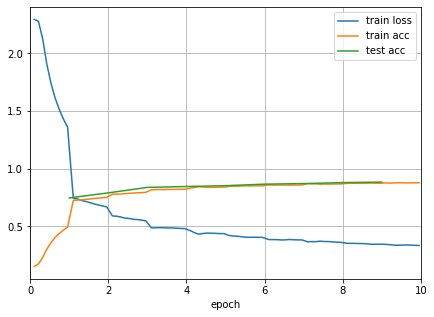

In [5]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)